In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from covapt_mt.covapt import covariance_model
from covapt_mt.utils import load_config_file

In [12]:
config_dict = load_config_file("config/get_covariance.yaml")

k_data = np.load(config_dict["input_dir"] + config_dict["k_array_file"])
k_0 = k_data["k_0"]
print(config_dict["output_dir"] + config_dict["covariance_file"])
C_data = np.load(config_dict["output_dir"] + config_dict["covariance_file"])
C_G, P_G = [], []
num_zbins = len(C_data.files)
num_tracers = config_dict["num_tracers"]
num_spectra = int(num_tracers*(num_tracers+1)/2)
num_kbins = len(k_0)

print(k_0)

for z in range(num_zbins):
    C_G.append(C_data["zbin_"+str(z)])
    P_G.append(np.linalg.inv(C_G[z]))

/home/joeadamo/Research/SPHEREx/covapt_mt/data/output_data/cov_emu_test.npz
[0.00792 0.01576 0.0236  0.03144 0.03928 0.04712 0.05496 0.0628  0.07064
 0.07848 0.08632 0.09416 0.102   0.10984 0.11768 0.12552 0.13336 0.1412
 0.14904 0.15688 0.16472 0.17256 0.1804  0.18824 0.19608]


In [13]:
def CorMat(cov):
    rms = np.sqrt(np.diag(cov))
    cor = np.copy(cov)
    for i in range(cov.shape[0]):
        for j in range(cov.shape[0]):
            cor[i,j] = cov[i,j]/(rms[i]*rms[j])
    return cor

ERROR! Covariance matrix is not positive definite!
0.0 675282982779613.4


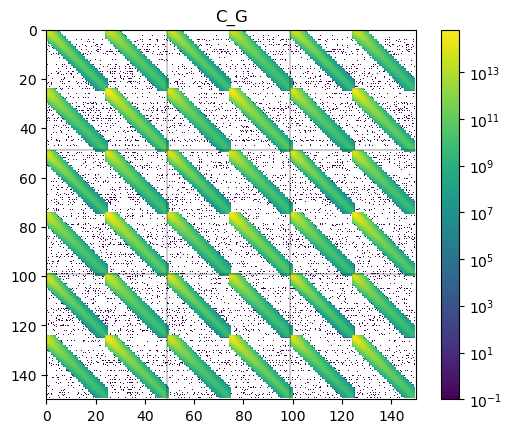

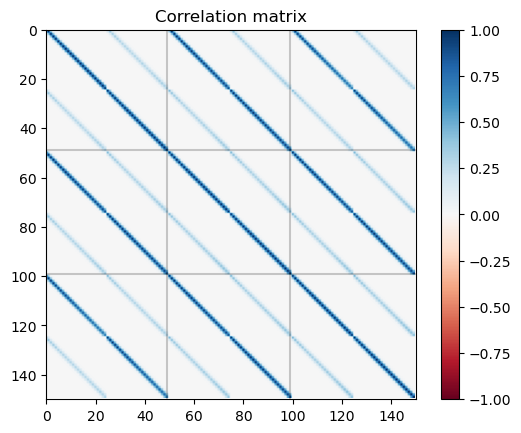

In [14]:
for z in range(num_zbins):

    try:
        L = np.linalg.cholesky(C_G[z])
        print("Covariance matrix is positive definite! :)")
    except:
        print("ERROR! Covariance matrix is not positive definite!")
    
    print(np.amin(C_G[z]), np.amax(C_G[z]))
    plt.figure()
    plt.title("C_G")
    img = plt.imshow(C_G[z], cmap="viridis",  norm=colors.LogNorm(vmin=0.1, vmax=np.amax(C_G[z])))
    #img = plt.imshow(C_G[z], cmap="RdBu",  norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_G[z]), vmax=np.amax(C_G[z])))
    for i in range(num_spectra):
        plt.axvline(i*num_kbins*2 - 1, c="black", alpha=0.2)
        plt.axhline(i*num_kbins*2 - 1, c="black", alpha=0.2)
    plt.xlim(0, num_spectra*2*num_kbins)
    plt.ylim(num_spectra*2*num_kbins, 0)
    plt.colorbar()
    
    plt.figure()
    plt.title("Correlation matrix")
    corr = CorMat(C_G[z])
    img = plt.imshow(corr, vmin=-1, vmax=1, cmap="RdBu")
    for i in range(num_spectra):
        plt.axvline(i*num_kbins*2 - 1, c="black", alpha=0.2)
        plt.axhline(i*num_kbins*2 - 1, c="black", alpha=0.2)
    plt.xlim(0, num_spectra*2*num_kbins)
    plt.ylim(num_spectra*2*num_kbins, 0)
    plt.colorbar()

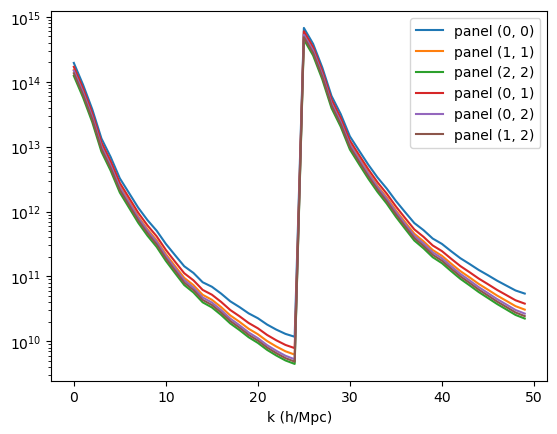

In [15]:
plt.plot(np.diag(C_G[0])[:50], label="panel (0, 0)")
plt.plot(np.diag(C_G[0])[50:100], label="panel (1, 1)")
plt.plot(np.diag(C_G[0])[100:], label="panel (2, 2)")
plt.plot(np.diag(C_G[0][:50, 50:100]), label="panel (0, 1)")
plt.plot(np.diag(C_G[0][:50, 100:]), label="panel (0, 2)")
plt.plot(np.diag(C_G[0][50:100, 100:]), label="panel (1, 2)")
#plt.plot(np.diag(C_G[0])[num_kbins:], label="(2, 2) diagonal")
#plt.xscale("log")
plt.yscale("log")

plt.xlabel("k (h/Mpc)")
plt.legend()

there are 4 negative eigenvalues!
there are 0 eigenvalues equal to 0!


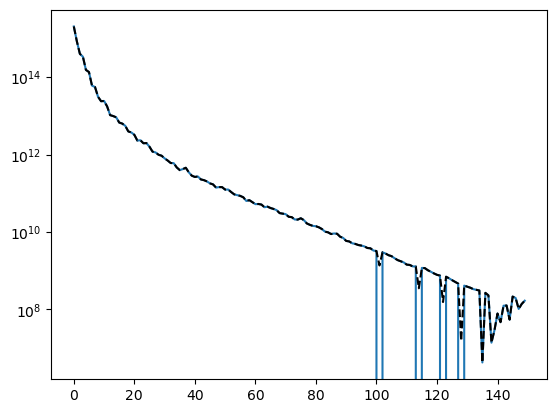

In [16]:
for z in range(num_zbins):
    eigvals_true, __ = np.linalg.eig(C_G[z])
    
    print("there are {:0.0f} negative eigenvalues!".format(len(eigvals_true[(eigvals_true < 0)])))
    print("there are {:0.0f} eigenvalues equal to 0!".format(len(eigvals_true[(eigvals_true == 0)])))
    plt.figure()
    plt.plot(eigvals_true)
    plt.plot(abs(eigvals_true), c="black", ls="--")
    plt.yscale("log")

'Fixed' Covariance matrix is positive definite! :)
there are 0 negative eigenvalues!


/home/joeadamo/miniconda3/envs/covapt/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


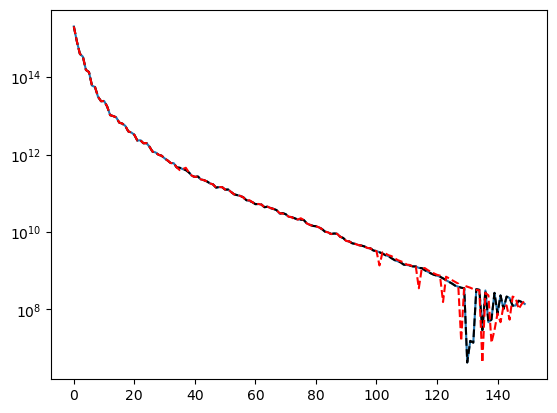

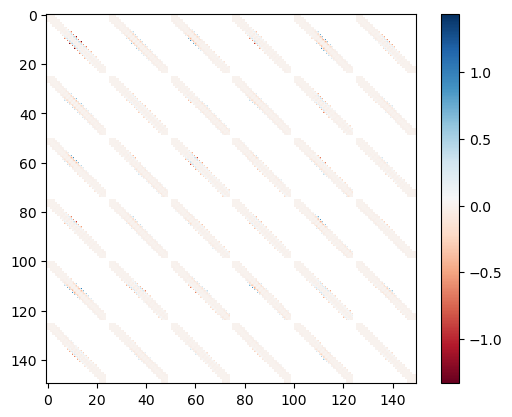

In [7]:
# TEMP FIX: manually set eigenvalues to positive

C_G_fixed = []
for z in range(num_zbins):
    eigvals, Q = np.linalg.eig(C_G[z])
    C_fixed = Q @ (np.diag(abs(eigvals)) @ np.linalg.inv(Q))

    try:
        L = np.linalg.cholesky(C_fixed)
        print("'Fixed' Covariance matrix is positive definite! :)")
    except:
        print("ERROR! 'Fixed' Covariance matrix is not positive definite!")
    
    eigvals, Q = np.linalg.eig(C_fixed)
    print("there are {:0.0f} negative eigenvalues!".format(len(eigvals[(eigvals < 0)])))
    plt.figure()
    plt.plot(eigvals)
    plt.plot(abs(eigvals), c="black", ls="--")
    plt.plot(abs(eigvals_true), c="red", ls="--")
    plt.yscale("log")
    
    plt.figure()
    plt.imshow(100*(C_fixed - C_G[0]) / C_G[0], cmap="RdBu")
    plt.colorbar()
    # plt.plot(np.diag(C_G[0]), label="raw matrix")
    # plt.plot(np.diag(C_fixed), ls="--", label="fixed matrix")
    # plt.yscale("log")
    # plt.legend()

In [8]:
# check if subsets of the covariance matrix are positive-definite
for z in range(num_zbins):
    for i in range(num_spectra):
        for j in range(num_spectra):
            C_sub = C_G[z][i*2*num_kbins: (i+1)*2*num_kbins,j*2*num_kbins: (j+1)*2*num_kbins]
            try:
                L = np.linalg.cholesky(C_sub)
                print("Partial covariance matrix ({:0.0f}, {:0.0f}) is positive-definite :)".format(i, j))
            except:
                print("Partial covariance matrix ({:0.0f}, {:0.0f}) is NOT positive-definite".format(i, j))
        #print(i*2*num_kbins, j*2*num_kbins)
        #C_sub = C_G[0][

C_sub = C_G[0][50:, 50:]
try:
    L = np.linalg.cholesky(C_sub)
    print("Partial covariance matrix is positive definite :)")
except:
    print("Partial covariance matrix is NOT positive-definite")

# plt.imshow(CorMat(C_sub), cmap="RdBu", vmin=-1, vmax=1)
# plt.colorbar()

Partial covariance matrix (0, 0) is positive-definite :)
Partial covariance matrix (0, 1) is positive-definite :)
Partial covariance matrix (0, 2) is positive-definite :)
Partial covariance matrix (1, 0) is positive-definite :)
Partial covariance matrix (1, 1) is positive-definite :)
Partial covariance matrix (1, 2) is positive-definite :)
Partial covariance matrix (2, 0) is positive-definite :)
Partial covariance matrix (2, 1) is positive-definite :)
Partial covariance matrix (2, 2) is positive-definite :)
Partial covariance matrix is positive definite :)


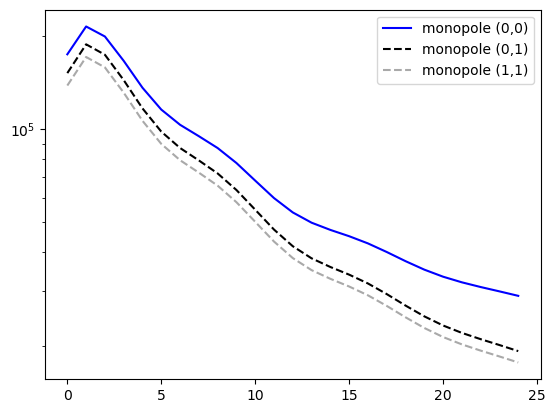

In [90]:
#pk = np.load("/home/joeadamo/Research/SPHEREx/spherex_emu/data/ps_fid.npy")
pk= np.load("/home/joeadamo/Research/SPHEREx/covapt_mt/data/input_data/ps_emu_test_2_tracers.npy")

# plt.plot(pk[0,0,0,:], label="idx 0")
# plt.plot(pk_2[0,0,0,:], ls="--", label="idx 0 2")
# plt.plot(pk[0,0,1,:], label="idx 1")
# plt.plot(pk_2[0,0,1,:], ls="--", label="idx 1 2")
# plt.legend()
# plt.yscale("log")

plt.figure()
plt.plot(pk[0,0,0,:], c="blue", label="monopole (0,0)")
#plt.plot(pk[0,3,0,:], c="red",label="monopole (1,1)")
#plt.plot(pk[0,5,0,:], c="green",label="monopole (2,2)")
#plt.axhline(1. / 0.00282, c="red", ls="--")
plt.plot(pk[0,1,0,:], c="black", ls="--", label="monopole (0,1)")
plt.plot(pk[0,2,0,:], c="darkgrey", ls="--", label="monopole (1,1)")
#plt.plot(pk[0,4,0,:], c="grey", ls="--", label="monopole (1,2)")
plt.legend()
plt.yscale("log")